# Predicting prices with a single-asset regression model

## Preparing the independent and target variables

In [1]:
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_jpm, meta_data = ts.get_daily_adjusted(
    symbol='JPM', outputsize='full')
df_gs, meta_data = ts.get_daily_adjusted(
    symbol='GS', outputsize='full')

In [2]:
import pandas as pd

df_x = pd.DataFrame({'GS': df_gs['5. adjusted close']})

In [3]:
jpm_prices = df_jpm['5. adjusted close']

## Writing the linear regression model

In [4]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()
        
        df.sort_index(inplace=True)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]

In [5]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018-01-01', 
                       end_date='2019-01-01', lookback_period=20)

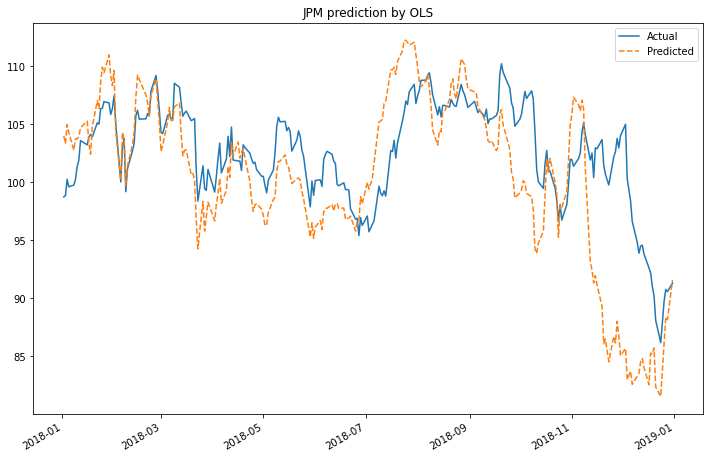

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

## Risk metrics for measuring prediction performance

### Mean absolute error (MAE) as a risk metric

In [7]:
from sklearn.metrics import mean_absolute_error

actual = linear_reg_model.df_result['Actual']
predicted = linear_reg_model.df_result['Predicted']

mae = mean_absolute_error(actual, predicted)
print('mean absolute error:', mae)

mean absolute error: 3.9653374890045643


#### Mean squared error (MSE) as a risk metric

In [8]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predicted)
print('mean squared error:', mse)

mean squared error: 29.717886354777313


### Explained variance score as a risk metric

In [9]:
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

explained variance score: -0.39960554614833677


### R<sup>2</sup> as a risk metric

In [10]:
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted) 
print('r2 score:', r2)

r2 score: -0.6027843457794251


## Ridge regression

In [11]:
from sklearn.linear_model import Ridge

class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

In [12]:
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

In [13]:
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, 
    explained_variance_score, r2_score
)
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))    

In [14]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 2.337483877210982
mean_squared_error: 9.403208688487673
explained_variance_score: 0.8799465425385613
r2_score: 0.8763227381038932


# Predicting returns with a cross-asset momentum model

## Preparing the independent variables

In [46]:
df_spx, meta_data = ts.get_daily_adjusted(
    symbol='MSFT', outputsize='full')  # MSFT is a temporary replacement symbol for SPX
df_gld, meta_data = ts.get_daily_adjusted(
    symbol='GLD', outputsize='full')
df_dxy, dxy_meta_data = ts.get_daily_adjusted(
    symbol='UUP', outputsize='full')
df_ief, meta_data = ts.get_daily_adjusted(
    symbol='IEF', outputsize='full')

In [47]:
import pandas as pd

df_assets = pd.DataFrame({
    'SPX': df_spx['5. adjusted close'],
    'GLD': df_gld['5. adjusted close'],
    'UUP': df_dxy['5. adjusted close'],
    'IEF': df_ief['5. adjusted close'],
}).dropna()

In [48]:
df_assets_1m = df_assets.pct_change(periods=20)
df_assets_1m.columns = ['%s_1m'%col for col in df_assets.columns]

df_assets_3m = df_assets.pct_change(periods=60)
df_assets_3m.columns = ['%s_3m'%col for col in df_assets.columns]

df_assets_6m = df_assets.pct_change(periods=120)
df_assets_6m.columns = ['%s_6m'%col for col in df_assets.columns]

df_assets_12m = df_assets.pct_change(periods=240)
df_assets_12m.columns = ['%s_12m'%col for col in df_assets.columns]

In [49]:
df_lagged = df_assets_1m.join(df_assets_3m)\
    .join(df_assets_6m)\
    .join(df_assets_12m)\
    .dropna()

In [50]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3189 entries, 2008-02-12 to 2020-10-09
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SPX_1m   3189 non-null   float64
 1   GLD_1m   3189 non-null   float64
 2   UUP_1m   3189 non-null   float64
 3   IEF_1m   3189 non-null   float64
 4   SPX_3m   3189 non-null   float64
 5   GLD_3m   3189 non-null   float64
 6   UUP_3m   3189 non-null   float64
 7   IEF_3m   3189 non-null   float64
 8   SPX_6m   3189 non-null   float64
 9   GLD_6m   3189 non-null   float64
 10  UUP_6m   3189 non-null   float64
 11  IEF_6m   3189 non-null   float64
 12  SPX_12m  3189 non-null   float64
 13  GLD_12m  3189 non-null   float64
 14  UUP_12m  3189 non-null   float64
 15  IEF_12m  3189 non-null   float64
dtypes: float64(16)
memory usage: 423.5 KB


## Preparing the target variables

In [51]:
y = jpm_prices.pct_change().dropna()

In [52]:
multi_linear_model = LinearRegressionModel()
multi_linear_model.learn(df_lagged, y, start_date='2018', 
                         end_date='2019', lookback_period=10)

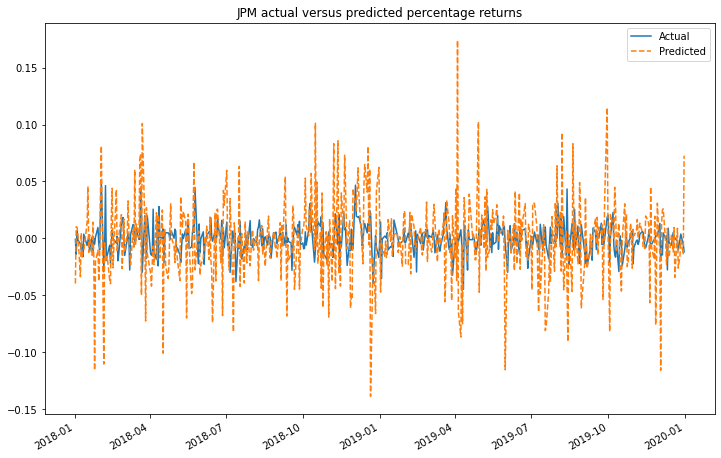

In [53]:
multi_linear_model.df_result.plot(
    title='JPM actual versus predicted percentage returns',
    style=['-', '--'], figsize=(12,8));

In [54]:
print_regression_metrics(multi_linear_model.df_result)

mean_absolute_error: 0.02689981807829978
mean_squared_error: 0.0013493539777125235
explained_variance_score: -7.059734389295647
r2_score: -7.0709553508518805


## An ensemble of decision trees

### Bagging regressor

In [55]:
from sklearn.ensemble import BaggingRegressor

class BaggingRegressorModel(LinearRegressionModel):
    def get_model(self):
        return BaggingRegressor(n_estimators=20, random_state=0)  

In [56]:
bagging = BaggingRegressorModel()
bagging.learn(df_lagged, y, start_date='2018', 
              end_date='2019', lookback_period=10)

In [57]:
print_regression_metrics(bagging.df_result)

mean_absolute_error: 0.011006572410558114
mean_squared_error: 0.00021376933542131845
explained_variance_score: -0.27855189964171956
r2_score: -0.2786287290541609


# Predicting trends with classification-based machine learning

## Preparing the target variables

In [58]:
import numpy as np
y_direction = y >= 0

In [59]:
y_direction.head(3)

date
2020-10-08     True
2020-10-07    False
2020-10-06    False
Name: 5. adjusted close, dtype: bool

In [60]:
flags = list(y_direction.unique())
flags.sort()

In [61]:
print(flags)

[False, True]


## Preparing the dataset of multiple assets as input variables

In [62]:
df_input = df_assets_1m.join(df_assets_3m).dropna()

In [63]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3369 entries, 2007-05-25 to 2020-10-09
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPX_1m  3369 non-null   float64
 1   GLD_1m  3369 non-null   float64
 2   UUP_1m  3369 non-null   float64
 3   IEF_1m  3369 non-null   float64
 4   SPX_3m  3369 non-null   float64
 5   GLD_3m  3369 non-null   float64
 6   UUP_3m  3369 non-null   float64
 7   IEF_3m  3369 non-null   float64
dtypes: float64(8)
memory usage: 236.9 KB


## Logistic regression

In [64]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression(solver='lbfgs')

In [65]:
logistic_reg_model = LogisticRegressionModel()
logistic_reg_model.learn(df_input, y_direction, start_date='2018', 
                         end_date='2019', lookback_period=100)

In [66]:
logistic_reg_model.df_result.head()

,Actual,Predicted
2018-01-02,False,False
2018-01-03,False,False
2018-01-04,True,False
2018-01-05,False,False
2018-01-08,False,False


### Risk metrics for measuring classification-based predictions

### Confusion matrix

In [67]:
from sklearn.metrics import confusion_matrix

df_result = logistic_reg_model.df_result    
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

matrix = confusion_matrix(actual, predicted)

In [68]:
print(matrix)

[[122 139]
 [109 133]]


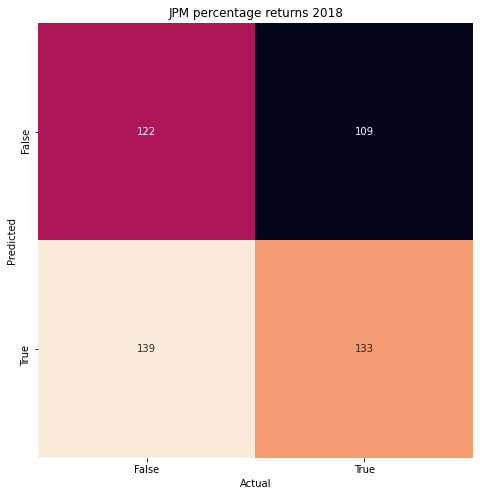

In [69]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,8))
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=flags, yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('JPM percentage returns 2018');

### Accuracy score

In [70]:
from sklearn.metrics import accuracy_score
print('accuracy_score:', accuracy_score(actual, predicted))

accuracy_score: 0.5069582504970179


### Precision score

In [71]:
from sklearn.metrics import precision_score
print('precision_score:', precision_score(actual, predicted))

precision_score: 0.4889705882352941


### Recall score

In [72]:
from sklearn.metrics import recall_score
print('recall_score:', recall_score(actual, predicted))

recall_score: 0.5495867768595041


### F1 Score

In [73]:
from sklearn.metrics import f1_score
print('f1_score:', f1_score(actual, predicted))

f1_score: 0.5175097276264591


## Support Vector Classifier

In [74]:
from sklearn.svm import SVC

class SVCModel(LogisticRegressionModel):
    def get_model(self):
        return SVC(C=1000, gamma='auto')

In [75]:
svc_model = SVCModel()
svc_model.learn(df_input, y_direction, start_date='2018', 
                end_date='2019', lookback_period=100)

In [76]:
df_result = svc_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

print('accuracy_score:', accuracy_score(actual, predicted))
print('precision_score:', precision_score(actual, predicted))
print('recall_score:', recall_score(actual, predicted))
print('f1_score:', f1_score(actual, predicted))    

accuracy_score: 0.5029821073558648
precision_score: 0.4823008849557522
recall_score: 0.45041322314049587
f1_score: 0.4658119658119658
